In [43]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import yaml

from floris.tools import FlorisInterface
import floris.tools.visualization as wakeviz

In [44]:
def load_floris(wake_model: str = "jensen.yaml", grid_method: str = "turbine_grid", grid_N:int = 3):
    # Instantiate FLORIS with the Jensen model
    input_dict = yaml.safe_load( open(f'inputs/{wake_model}', 'r') )
    fi = FlorisInterface(input_dict)

    # Update solver dict
    solver_dict = input_dict["solver"]
    solver_dict["type"] = grid_method
    solver_dict["turbine_grid_points"] = grid_N

    # Set up the wind farm
    D = 126.0
    SPACING = 5.0
    layout_x = [
        0,
        D * 1 * SPACING,
        D * 2 * SPACING,
    ]
    layout_y = [
        0,
        0,
        0,
    ]

    fi.reinitialize(
        layout_x=layout_x,
        layout_y=layout_y,
        wind_speeds=[8.0],
        wind_shear=1.0,  # Use a linear wind shear for easier comparison of the numerical integration
        solver_settings=solver_dict,
    )

    return fi

[8.60623309 6.64815365 6.19762848]
[8.38084153 6.47366289 6.00791338]


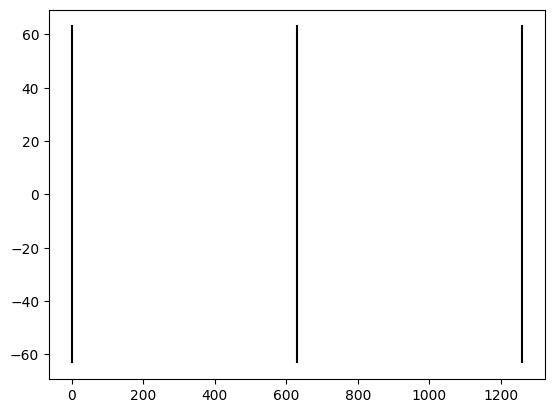

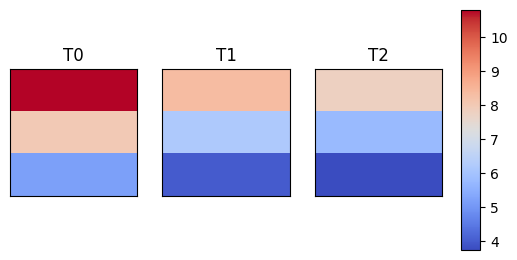

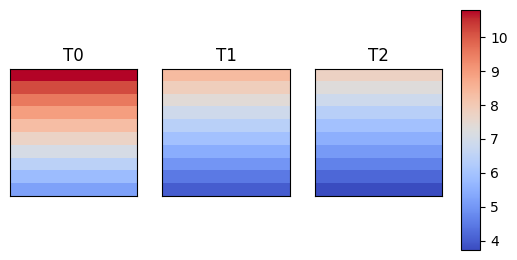

In [45]:
fi = load_floris(grid_method="turbine_grid", grid_N=3)
fi.calculate_wake()

# Plot the layout
wakeviz.plot_turbines_with_fi(fi)

# Compare the wake profile with min and max number of points on rotor plane
fi = load_floris(grid_method="turbine_grid", grid_N=3)
fi.calculate_wake()
wakeviz.plot_rotor_values(
    fi.floris.flow_field.u,
    wd_index=range(0,1),
    ws_index=range(0,1),
    n_rows=1,
    n_cols=3
)
print(fi.turbine_average_velocities[0, 0])

fi = load_floris(grid_method="turbine_grid", grid_N=10)
fi.calculate_wake()
wakeviz.plot_rotor_values(
    fi.floris.flow_field.u,
    wd_index=range(0,1),
    ws_index=range(0,1),
    n_rows=1,
    n_cols=3
)
print(fi.turbine_average_velocities[0, 0])

N grid points   GR Turbine 1 Power (MW)   GR Farm Power (MW)   CB Turbine 1 Power (MW)   CB Farm Power (MW)
            1                  1.707            3.083                  1.707                  3.083
            2                  2.338            4.295                  2.338                  4.295
            3                  2.129            3.895                  2.338                  4.295
            4                  2.056            3.756                  2.338                  4.295
            5                  2.022            3.688                  2.338                  4.295
            6                  2.002            3.648                  2.338                  4.295
            7                  1.989            3.621                  2.338                  4.295
            8                  1.979            3.602                  2.338                  4.295
            9                  1.972            3.587                  2.338                

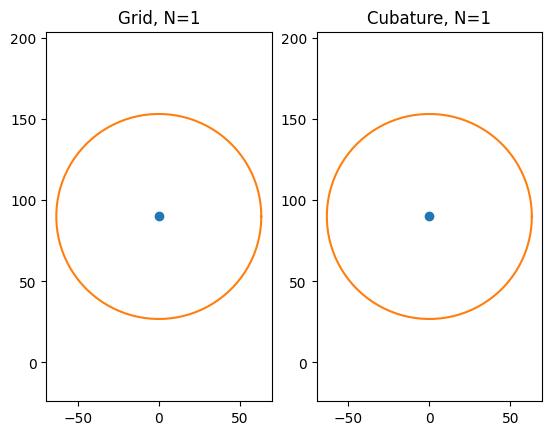

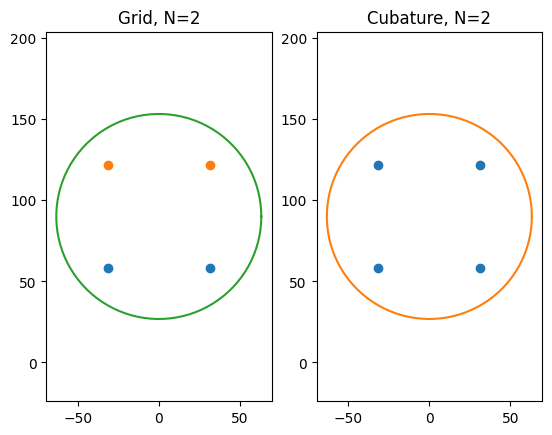

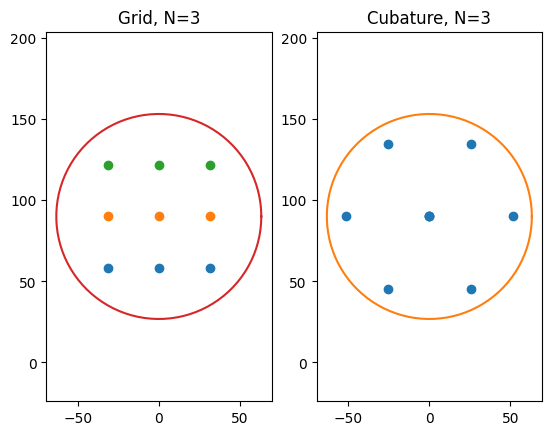

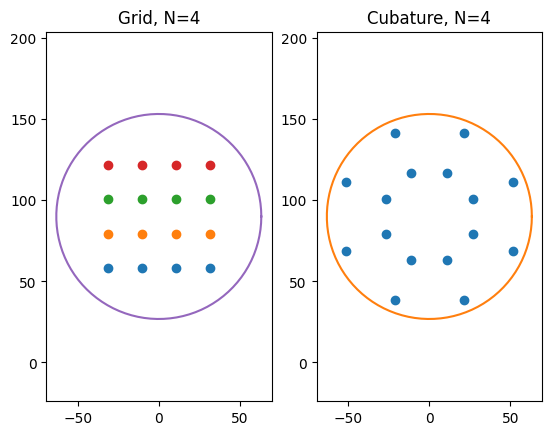

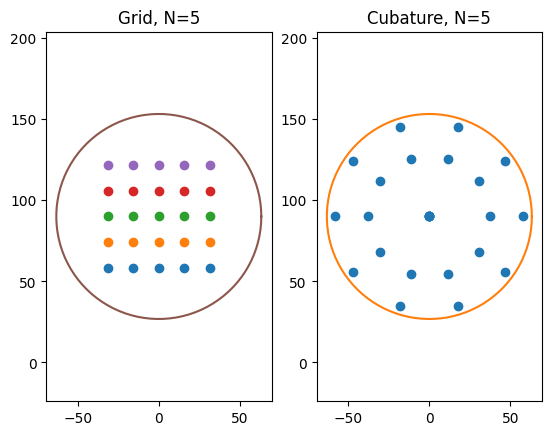

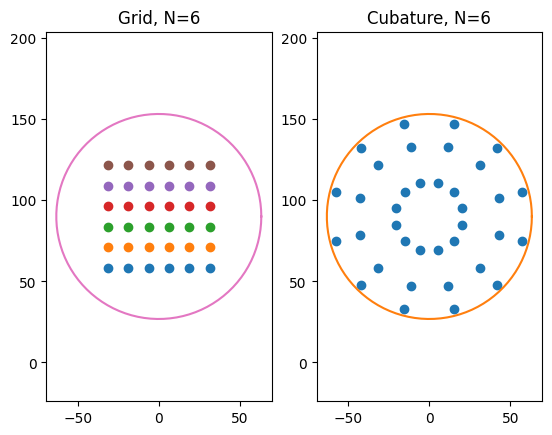

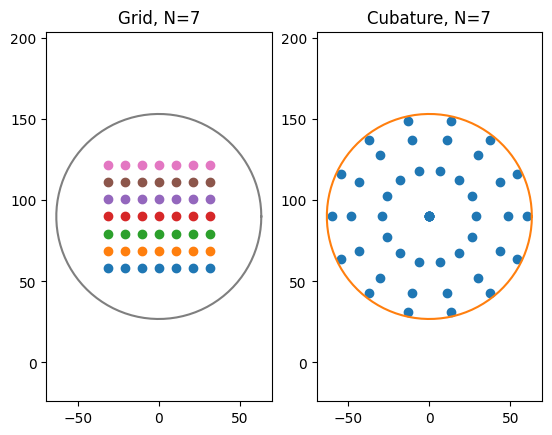

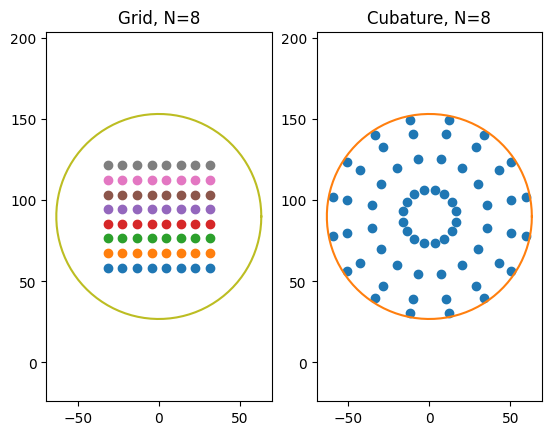

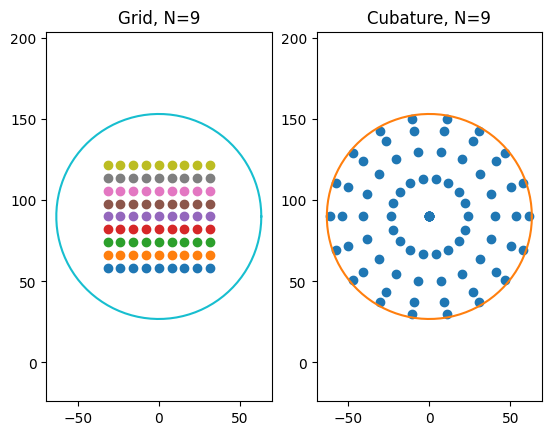

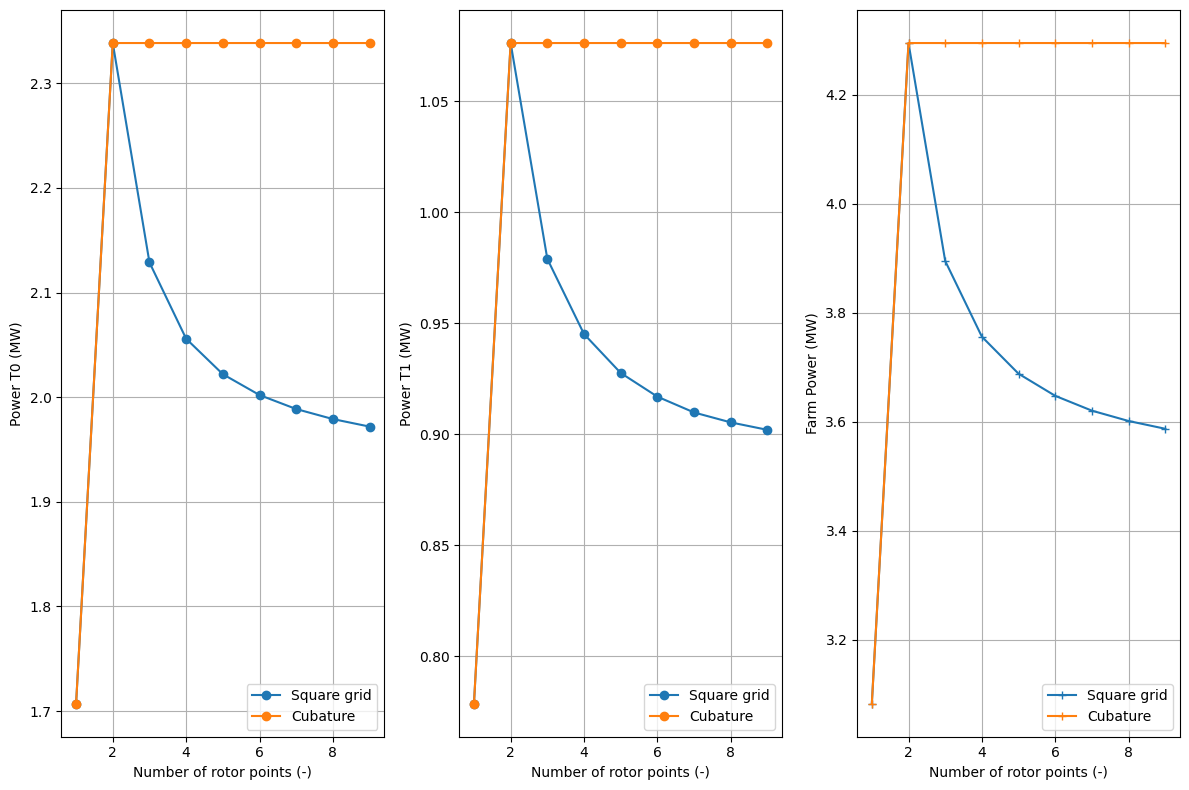

In [56]:
# Show grid dependence for a single unwaked turbine only impacted by the shear profile
grid_points_array = range(1, 10)

turbine_power_array_grid = np.zeros((len(grid_points_array), fi.floris.farm.n_turbines))
farm_power_array_grid = np.zeros(len(grid_points_array))

turbine_power_array_cubature = np.zeros((len(grid_points_array), fi.floris.farm.n_turbines))
farm_power_array_cubature = np.zeros(len(grid_points_array))

print(f"{'N grid points':13s}   {'GR Turbine 1 Power (MW)':21s}   {'GR Farm Power (MW)':15s}   {'CB Turbine 1 Power (MW)':21s}   {'CB Farm Power (MW)':15s}")
for i, n_rotor_points in enumerate(grid_points_array):

    # Figure placeholder
    fig, ax = plt.subplots(ncols=2)

    # Calculate properties with traditional square rotor grid
    fi = load_floris(grid_N=n_rotor_points)
    fi.calculate_wake()
    turbine_power_array_grid[i] = fi.get_turbine_powers()[0, 0] / 1e6  # Calculate turbine and farm power
    farm_power_array_grid[i] = fi.get_farm_power()[0, 0] / 1e6  # Calculate turbine and farm power

    # Plot square grid
    ax[0].plot(fi.floris.grid.y[0, 0, 0, :], fi.floris.grid.z[0, 0, 0, :], 'o')
    x = 63.2 * np.cos(np.linspace(0.0, 2*np.pi, 100))
    y = 63.2 * np.sin(np.linspace(0.0, 2*np.pi, 100))
    ax[0].plot(x, 90.0 + y)
    ax[0].axis("equal")
    ax[0].set_title(f"Grid, N={n_rotor_points}")

    # Calculate properties with traditional square rotor grid
    fi = load_floris(grid_method="cubature_grid", grid_N=n_rotor_points)
    fi.calculate_wake()
    turbine_power_array_cubature[i] = fi.get_turbine_powers()[0, 0] / 1e6  # Calculate turbine and farm power
    farm_power_array_cubature[i] = fi.get_farm_power()[0, 0] / 1e6  # Calculate turbine and farm power
    print(f"{n_rotor_points:13d}   {turbine_power_array_grid[i,0]:20.3f}   {farm_power_array_grid[i]:14.3f}   {turbine_power_array_cubature[i,0]:20.3f}   {farm_power_array_cubature[i]:20.3f}")

    # Plot cubature grid
    ax[1].plot(fi.floris.grid.y[0, 0, 0, :], fi.floris.grid.z[0, 0, 0, :], 'o')
    x = 63.2 * np.cos(np.linspace(0.0, 2*np.pi, 100))
    y = 63.2 * np.sin(np.linspace(0.0, 2*np.pi, 100))
    ax[1].plot(x, 90.0 + y)
    ax[1].axis("equal")
    ax[1].set_title(f"Cubature, N={n_rotor_points}")


fig, axes = plt.subplots(1, 3, figsize=(12,8))
axes[0].plot(grid_points_array, turbine_power_array_grid[:,0], '-o', label="Square grid")
axes[0].plot(grid_points_array, turbine_power_array_cubature[:,0], '-o', label="Cubature")
# axes[0].plot([0, grid_points_array[-1]], 2 * [turbine_power_array[-1,0]], '--')
# axes[0].plot([0, grid_points_array[1]], 2 * [turbine_power_array[1,0]], '--')  # This is the typical 3x3 grid
axes[0].grid(True)
axes[0].set_xlabel('Number of rotor points (-)')
axes[0].set_ylabel('Power T0 (MW)')
axes[0].legend()

axes[1].plot(grid_points_array, turbine_power_array_grid[:,1], '-o', label="Square grid")
axes[1].plot(grid_points_array, turbine_power_array_cubature[:,1], '-o', label="Cubature")
# axes[0].plot([0, grid_points_array[-1]], 2 * [turbine_power_array[-1,0]], '--')
# axes[0].plot([0, grid_points_array[1]], 2 * [turbine_power_array[1,0]], '--')  # This is the typical 3x3 grid
axes[1].grid(True)
axes[1].set_xlabel('Number of rotor points (-)')
axes[1].set_ylabel('Power T1 (MW)')
axes[1].legend()

axes[2].plot(grid_points_array, farm_power_array_grid, '-+', label="Square grid")
axes[2].plot(grid_points_array, farm_power_array_cubature, '-+', label="Cubature")
axes[2].grid(True)
axes[2].set_xlabel('Number of rotor points (-)')
axes[2].set_ylabel('Farm Power (MW)')
axes[2].legend()
fig.tight_layout()

# Get statistics for both methods
max_power = max(farm_power_array_grid)
min_power = min(farm_power_array_grid)
print(f"Grid: Max: {max_power:9.3f}")
print(f"Grid: Min: {min_power:9.3f}")
print(f"Grid: Diff: {100*abs(max_power - min_power) / max_power : 3.1f}%")

max_power = max(farm_power_array_cubature)
min_power = min(farm_power_array_cubature)
print(f"Cubature: Max: {max_power:9.3f}")
print(f"Cubature: Min: {min_power:9.3f}")
print(f"Cubature: Diff: {100*abs(max_power - min_power) / max_power : 3.1f}%")

(1, 1, 3, 25, 1)
(1, 1, 3, 25, 1)
(1, 1, 3, 25, 1)


(-69.48659055254818, 69.51840907393087, 20.4887506441122, 159.5112493558878)

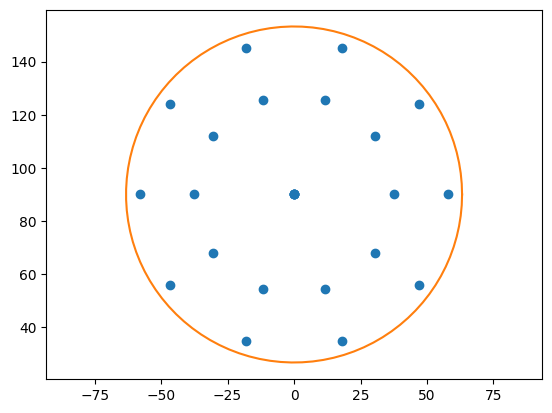

In [57]:
# Compare the wake profile with min and max number of points on rotor plane
fi = load_floris(grid_method="cubature_grid", grid_N=5)

# fi.calculate_wake()
print(np.shape(fi.floris.grid.x))
print(np.shape(fi.floris.grid.y))
print(np.shape(fi.floris.grid.z))

fig, ax = plt.subplots()
ax.plot(fi.floris.grid.y[0, 0, 0, :], fi.floris.grid.z[0, 0, 0, :], 'o')
x = 63.2 * np.cos(np.linspace(0.0, 2*np.pi, 100))
y = 63.2 * np.sin(np.linspace(0.0, 2*np.pi, 100))
ax.plot(x, 90.0 + y)
ax.axis("equal")


# cubature_turbine_power = fi.get_turbine_powers()[0, 0] / 1e6
# cubature_farm_power = fi.get_farm_power()[0, 0] / 1e6

# print(f"{'rotor grid':13s}   {turbine_power_array[-1,0]:20.3f}   {farm_power_array[-1]:14.3f}")
# print(f"{'cubature grid':13s}   {cubature_turbine_power[0]:20.3f}   {cubature_farm_power:14.3f}")
# print(f"Diff: {100*abs(cubature_farm_power - min_power) / min_power : 3.1f}%")